In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
def shuffle_examples(X,y):
  p = np.random.permutation(len(X))
  return X[p],y[p]

def split_train_validation_test(X,y,p_t,p_tv):
  n = int(p_t*len(X))
  m = int(p_tv*len(X))
  return X[:n],y[:n],X[n:m],y[n:m],X[m:],y[m:]   

def scale(x):
  mu = np.mean(x,axis=0)
  st = np.std(x,axis=0)
  return (x-mu)/st,mu,st  

def sigmoid(x):
  return 1/(1+np.exp(-x))

def relu(x):
  return np.maximum(0,x)  

def softmax(X):
  return np.exp(X)/(np.sum(np.exp(X),axis=1).reshape(-1,1))   

def sigmoid_p(x):
  return sigmoid(x)*(1-sigmoid(x))

def relu_p(x):
  return 1*(x >= 0)    

def error_bin(y,y_hat):
  return -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)

def error_bin_reg(y,y_hat,W,la):
  J_reg = error_bin(y,y_hat)
  for l in range(1,len(W)):
    J_reg = J_reg + la*np.sum(W[l]**2)/len(y)
  return J_reg      

def error_softmax(y,y_hat):
  return -np.sum(y*np.log(y_hat))/len(y)
  
def error_softmax_reg(y,y_hat,W,la):
  J_reg = error_softmax(y,y_hat)
  for l in range(1,len(W)):
    J_reg = J_reg + la*np.sum(W[l]**2)/len(y)
  return J_reg   
  
def accuracy_recall_precision(y_hat,y):
  y_hat_cat = 1*(y_hat > 0.5)
  correct_predictions = np.sum(y_hat_cat == y)
  predictions = len(y)
  true_positives = np.sum((y_hat_cat == 1) & (y == 1))
  positives = np.sum(y)
  predicted_positives = np.sum(y_hat_cat)
  accuracy = correct_predictions/predictions
  recall = true_positives/positives
  precision = true_positives/predicted_positives
  return accuracy, recall, precision  

# y is a one dimensional array y_1d = [0,2,1,3,0,2] (the categories of the examples)
# y_hat is 2d
def accuracy_softmax(y_hat,y_1d):
  y_hat_1d = np.argmax(y_hat,axis=1)
  correct_predictions = np.sum(y_hat_1d == y_1d)
  predictions = len(y_1d)
  accuracy = correct_predictions/predictions
  return accuracy
  
def h(x,act):
  if act == 'sigmoid':
    return sigmoid(x)
  if act == 'relu':
    return relu(x)
  if act == 'identity':
    return x
  if act == 'tanh':
    return np.tanh(x)
  if act == 'softmax':
    return softmax(x)  
  return 'Problem' 

def h_p(x,act):
  if act == 'sigmoid':
    return sigmoid_p(x)
  if act == 'relu':
    return relu_p(x)
  if act == 'identity':
    return 1
  if act == 'tanh':
    return 1/(np.cosh(x))**2
  return 'Problem'  

def As_Zs(X,W,b,act):
  A = [X]
  Z = [0]
  for l in range(1,len(b)):
    Z.append(np.matmul(A[-1],W[l])+b[l])
    A.append(h(Z[-1],act[l]))
  return A,Z 

# y is 1d
def gradients_bin(A,Z,act,W,y):
  y_hat = A[-1]
  l = len(W)-1
  DJ_DW = []
  DJ_Db = []
  DJ_DZ = (y_hat - y.reshape(-1,1))/len(y)
  while l > 1:
    DJ_DA = np.matmul(DJ_DZ,W[l].T)
    DJ_DW.insert(0,np.matmul(A[l-1].T,DJ_DZ)) 
    DJ_Db.insert(0,np.sum(DJ_DZ,axis=0))
    DJ_DZ = DJ_DA*h_p(Z[l-1],act[l-1])
    l = l-1
  DJ_DA = np.matmul(DJ_DZ,W[1].T)
  DJ_DW.insert(0,np.matmul(A[0].T,DJ_DZ)) 
  DJ_Db.insert(0,np.sum(DJ_DZ,axis=0)) 
  DJ_DW.insert(0,0) 
  DJ_Db.insert(0,0)  
  return DJ_DW,DJ_Db  

# y is 2d
def gradients_softmax(A,Z,act,W,y):
  y_hat = A[-1]
  l = len(W)-1
  DJ_DW = []
  DJ_Db = []
  DJ_DZ = (y_hat - y)/len(y)
  while l > 1:
    DJ_DA = np.matmul(DJ_DZ,W[l].T)
    DJ_DW.insert(0,np.matmul(A[l-1].T,DJ_DZ)) 
    DJ_Db.insert(0,np.sum(DJ_DZ,axis=0))
    DJ_DZ = DJ_DA*h_p(Z[l-1],act[l-1])
    l = l-1
  DJ_DA = np.matmul(DJ_DZ,W[1].T)
  DJ_DW.insert(0,np.matmul(A[0].T,DJ_DZ)) 
  DJ_Db.insert(0,np.sum(DJ_DZ,axis=0)) 
  DJ_DW.insert(0,0) 
  DJ_Db.insert(0,0)  
  return DJ_DW,DJ_Db  

def update_parameters(W,b,DJ_DW,DJ_Db,c):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l]
    b[l] = b[l] - c*DJ_Db[l]
  return W, b  

def update_parameters_reg(W,b,DJ_DW,DJ_Db,c,m,la):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l] - 2*c*la*W[l]/m
    b[l] = b[l] - c*DJ_Db[l] 
  return W, b  

def initialize_W_and_b(n):
  W = [0]
  b = [0]
  for l in range(1,len(n)):
    W.append(np.random.randn(n[l-1],n[l])/np.sqrt(n[l-1]))
    b.append(np.zeros(n[l]))
  return W, b 

def steepest_bin(n,act,X,y,epochs,c):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_bin(y,y_hat.reshape(-1)))
    DJ_DW, DJ_Db = gradients_bin(A,Z,act,W,y)
    W, b = update_parameters(W,b,DJ_DW,DJ_Db,c)
  return W, b, J_list   

def steepest_softmax(n,act,X,y,epochs,c):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    if i%100 == 0:
      print(i)
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_softmax(y,y_hat))
    DJ_DW, DJ_Db = gradients_softmax(A,Z,act,W,y)
    W, b = update_parameters(W,b,DJ_DW,DJ_Db,c)
  return W, b, J_list   
  
def steepest_bin_reg(n,act,X,y,epochs,c,la):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_bin_reg(y,y_hat.reshape(-1),W,la))
    DJ_DW, DJ_Db = gradients_bin(A,Z,act,W,y)
    W, b = update_parameters_reg(W,b,DJ_DW,DJ_Db,c,len(y),la)
  return W, b, J_list           

def steepest_softmax_reg(n,act,X,y,epochs,c,la):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_softmax_reg(y,y_hat,W,la))
    DJ_DW, DJ_Db = gradients_softmax(A,Z,act,W,y)
    W, b = update_parameters_reg(W,b,DJ_DW,DJ_Db,c,len(y),la)
  return W, b, J_list           

def predict(X,W,b,act):
  A,Z = As_Zs(X,W,b,act)
  return A[-1]

def scale_predict(X,X_train_mean,X_train_std,W,b,act):
  return predict((X-X_train_mean)/X_train_std,W,b,act)

def labels_1d_2d(y,n_c):
  return 1*(np.arange(n_c).reshape(1,n_c) == y.reshape(len(y),1))   

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
df = pd.read_csv('/content/drive/MyDrive/Data/loan_info.csv')

In [87]:
df[:10]

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male
7,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male
8,PAIDOFF,300,7,9/10/2016,9/16/2016,29,college,male
9,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,High School or Below,male


In [90]:
df['High School or Below'] = 1*(df['education'] == 'High School or Below')
df[:10]

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,High School or Below
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male,1
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female,0
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male,0
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female,0
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male,0
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male,0
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male,0
7,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male,0
8,PAIDOFF,300,7,9/10/2016,9/16/2016,29,college,male,0
9,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,High School or Below,male,1


In [91]:
df['college'] = 1*(df['education'] == 'college')
df['Bechalor'] = 1*(df['education'] == 'Bechalor')
df['Master or Above'] = 1*(df['education'] == 'Master or Above')
df[:10]

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,High School or Below,college,Bechalor,Master or Above
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male,1,0,0,0
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female,0,0,1,0
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male,0,1,0,0
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female,0,1,0,0
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male,0,1,0,0
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male,0,1,0,0
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male,0,1,0,0
7,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male,0,1,0,0
8,PAIDOFF,300,7,9/10/2016,9/16/2016,29,college,male,0,1,0,0
9,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,High School or Below,male,1,0,0,0


In [92]:
df = df.drop(['education'], axis=1)

In [93]:
df.head(10)

,loan_status,Principal,terms,effective_date,due_date,age,Gender,High School or Below,college,Bechalor,Master or Above
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,male,1,0,0,0
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,female,0,0,1,0
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,male,0,1,0,0
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,female,0,1,0,0
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,male,0,1,0,0
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,male,0,1,0,0
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,male,0,1,0,0
7,PAIDOFF,800,15,9/10/2016,9/24/2016,26,male,0,1,0,0
8,PAIDOFF,300,7,9/10/2016,9/16/2016,29,male,0,1,0,0
9,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,male,1,0,0,0


In [94]:
df['male'] = 1*(df['Gender'] == 'male')
df['female'] = 1*(df['Gender'] == 'female')
df = df.drop(['Gender'], axis=1)

In [95]:
df.head(10)

,loan_status,Principal,terms,effective_date,due_date,age,High School or Below,college,Bechalor,Master or Above,male,female
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,1,0,0,0,1,0
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,0,0,1,0,0,1
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,0,1,0,0,1,0
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,0,1,0,0,0,1
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,0,1,0,0,1,0
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,0,1,0,0,1,0
6,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,0,1,0,0,1,0
7,PAIDOFF,800,15,9/10/2016,9/24/2016,26,0,1,0,0,1,0
8,PAIDOFF,300,7,9/10/2016,9/16/2016,29,0,1,0,0,1,0
9,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,1,0,0,0,1,0


In [96]:
df = df.drop(['effective_date'], axis=1)
df = df.drop(['due_date'], axis=1)

In [97]:
df.head(10)

,loan_status,Principal,terms,age,High School or Below,college,Bechalor,Master or Above,male,female
0,PAIDOFF,1000,30,45,1,0,0,0,1,0
1,PAIDOFF,1000,30,33,0,0,1,0,0,1
2,PAIDOFF,1000,15,27,0,1,0,0,1,0
3,PAIDOFF,1000,30,28,0,1,0,0,0,1
4,PAIDOFF,1000,30,29,0,1,0,0,1,0
5,PAIDOFF,1000,30,36,0,1,0,0,1,0
6,PAIDOFF,1000,30,28,0,1,0,0,1,0
7,PAIDOFF,800,15,26,0,1,0,0,1,0
8,PAIDOFF,300,7,29,0,1,0,0,1,0
9,PAIDOFF,1000,15,39,1,0,0,0,1,0


In [98]:
y = 1*(df['loan_status'] == 'PAIDOFF').values

In [100]:
dX = df.drop(['loan_status'], axis=1)

In [102]:
X = dX.to_numpy()

In [103]:
X,y = shuffle_examples(X,y)

In [104]:
p_t = 0.8
p_tv = 0.9
X_train, y_train, X_val, y_val, X_test, y_test = split_train_validation_test(X,y,p_t,p_tv)

In [105]:
len(y)

346

In [106]:
X_train_scaled, X_train_mean, X_train_std = scale(X_train)

In [127]:
X_train
y

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [128]:
n = [X_train_scaled.shape[1], 8, 4, 2, 1]
act = [None,'relu', 'relu','relu', 'sigmoid']
c = 0.1
epochs = 200
n

[9, 8, 4, 2, 1]

In [129]:
W, b, J_list = steepest_bin(n,act,X_train_scaled,y_train,epochs,c)

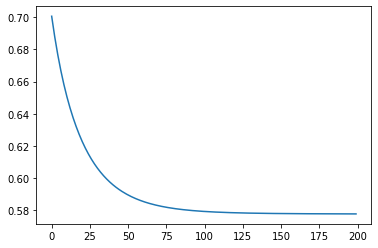

In [130]:
plt.plot(J_list)

In [131]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act).reshape(-1)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_train))
print('c e error =',error_bin(y_train,y_hat))

accuracy, recall, precision = (0.7355072463768116, 1.0, 0.7355072463768116)
c e error = 0.5775561073529397


In [132]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act).reshape(-1)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_val))
print('c e error =',error_bin(y_val,y_hat))

accuracy, recall, precision = (0.8857142857142857, 1.0, 0.8857142857142857)
c e error = 0.4265022435729396


In [133]:
y_hat = scale_predict(X_test,X_train_mean,X_train_std,W,b,act).reshape(-1)
print('accuracy, recall, precision =', accuracy_recall_precision(y_hat,y_test))
print('c e error =',error_bin(y_test,y_hat))

accuracy, recall, precision = (0.7428571428571429, 1.0, 0.7428571428571429)
c e error = 0.5708246138804625
